<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2 - Singapore Housing Data and Kaggle Challenge - PART 2

---
# PART 2 - Exploratory Data Analysis



---

Import required libraries:

In [1]:
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

import seaborn               as sns
import matplotlib.pyplot     as plt
import matplotlib.ticker as mticker

import statsmodels.api as sm
import pickle

%matplotlib inline

In [2]:
# Setting the print options to display full numbers (no scientific notation)
pd.options.display.float_format = '{:.2f}'.format

Import train_sel pkl file from notebook 2_1:

In [3]:
train = pickle.load(open('./pkl/train_sel.pkl', 'rb'))

Compared to the final selected features at the end of Notebook 2_1, I am going to bring in some new features again, for further exploration:

In [4]:
print(train.shape)
train.head()

(150634, 43)


floor_area_sqm  resale_price  tranc_year  tranc_month  mid_storey  hdb_age  \
0           90.00     680000.00        2016            5          11       15   
1          130.00     665000.00        2012            7           8       34   
2          144.00     838000.00        2013            7          14       24   
3          103.00     550000.00        2012            4           3       29   
4           83.00     298000.00        2017           12           2       34   

   max_floor_lvl  total_dwelling_units  1room_sold  2room_sold  ...  \
0             25                   142           0           0  ...   
1              9                   112           0           0  ...   
2             16                    90           0           0  ...   
3             11                    75           0           0  ...   
4              4                    48           0           0  ...   

   mrt_interchange  pri_sch_affiliation  affiliation             town  \
0                0                    1            0  KALLANG/WHAMPOA   
1                1                    1            0           BISHAN   
2                0                    0            0      BUKIT BATOK   
3                1                    1            1           BISHAN   
4                0                    0            0           YISHUN   

        street_name       full_flat_type  planning_area     mrt_name  \
0  UPP BOON KENG RD       4 ROOM Model A        Kallang      Kallang   
1      BISHAN ST 13      5 ROOM Improved         Bishan       Bishan   
2    BT BATOK ST 25  EXECUTIVE Apartment    Bukit Batok  Bukit Batok   
3      BISHAN ST 22       4 ROOM Model A         Bishan       Bishan   
4      YISHUN ST 81    4 ROOM Simplified         Yishun       Khatib   

                            pri_sch_name  \
0               Geylang Methodist School   
1  Kuo Chuan Presbyterian Primary School   
2                  Keming Primary School   
3                   Catholic High School   
4              Naval Base Primary School   

                              sec_sch_name  
0                 Geylang Methodist School  
1  Kuo Chuan Presbyterian Secondary School  
2             Yusof Ishak Secondary School  
3                     Catholic High School  
4             Orchid Park Secondary School  

[5 rows x 43 columns]

---
## 2.1 Further exploration / Feature Engineering

### 2.1.1 Planning areas

Some potential aspects to explore:
* Resale prices over time (by planning area)
* Feature engineer planning areas into district numbers
* Feature engineer mature/non-mature estates


#### Exploring resale prices over time (by planning area)

Just for this study, bring in original df:

In [66]:
train_og = pickle.load(open('./pkl/train_clean.pkl', 'rb'))

In [67]:
train_og['planning_area'].unique()

array(['Kallang', 'Bishan', 'Bukit Batok', 'Yishun', 'Geylang', 'Hougang',
       'Bedok', 'Sengkang', 'Tampines', 'Serangoon', 'Bukit Merah',
       'Bukit Panjang', 'Woodlands', 'Jurong West', 'Toa Payoh',
       'Choa Chu Kang', 'Sembawang', 'Novena', 'Ang Mo Kio', 'Pasir Ris',
       'Clementi', 'Punggol', 'Jurong East', 'Rochor', 'Queenstown',
       'Bukit Timah', 'Outram', 'Tanglin', 'Marine Parade',
       'Western Water Catchment', 'Downtown Core', 'Changi'], dtype=object)

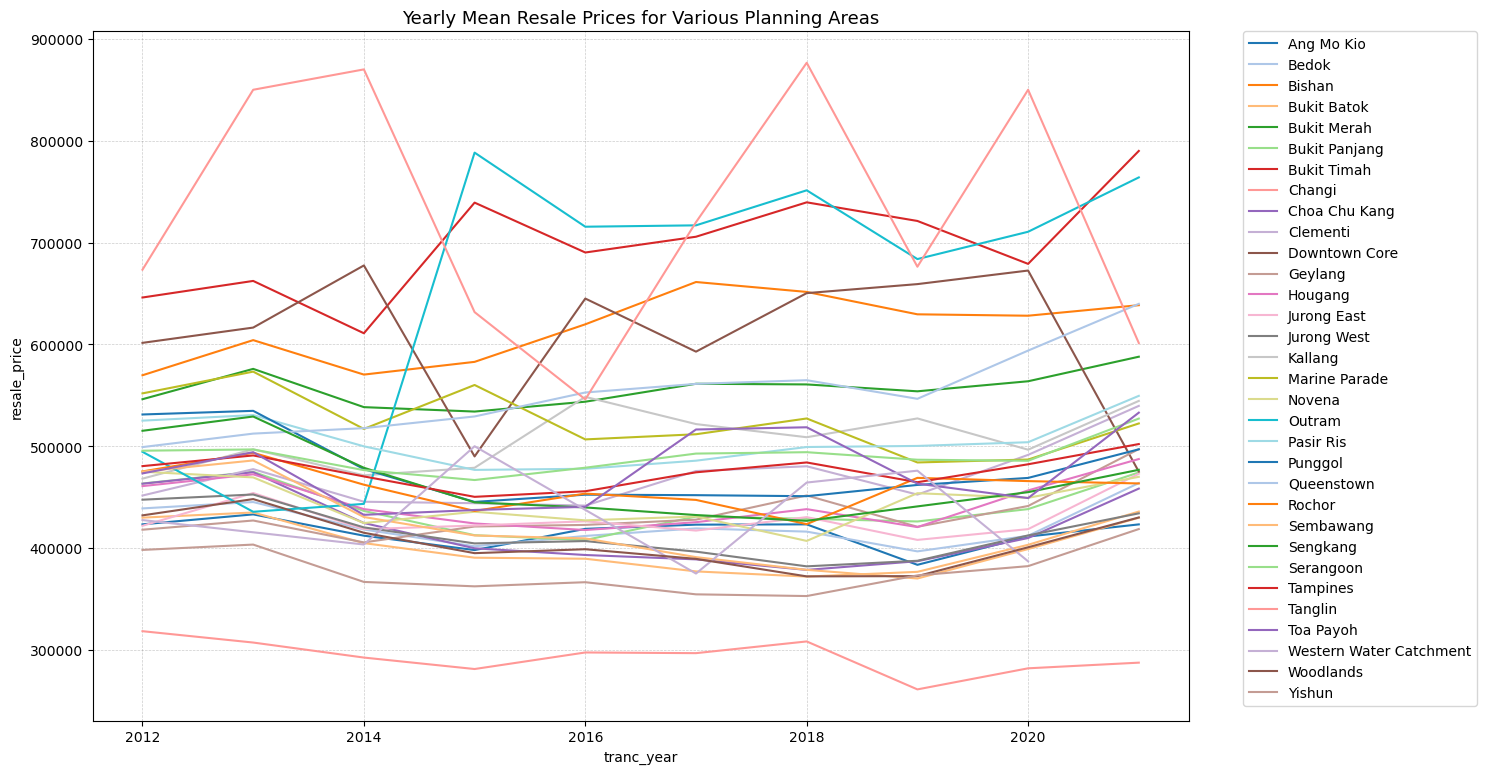

In [68]:
# Calculate the yearly mean resale prices
yearly_mean_prices = train_og.groupby(['tranc_year', 'planning_area'])['resale_price'].mean().reset_index()

# Establish the size of the figure.
plt.figure(figsize=(15, 8))

# Define a custom color palette with more distinct colors
custom_palette = sns.color_palette("tab20", n_colors=len(train_og['planning_area'].unique()))

# Plot the mean resale prices over time for various planning areas without markers
sns.lineplot(x='tranc_year', y='resale_price', hue='planning_area', data=yearly_mean_prices, palette=custom_palette, markers=False, err_style=None)

# Create a grid in the background.
plt.grid(True, linewidth=0.5, linestyle='--', c='black', alpha=0.2)

# Create tick mark labels on the X, Y axis without rotating them.
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Create title.
plt.title("Yearly Mean Resale Prices for Various Planning Areas", fontsize=13)

# Move the legend outside the plot area to avoid overlapping with the lines
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Show the plot
plt.tight_layout()
plt.show()

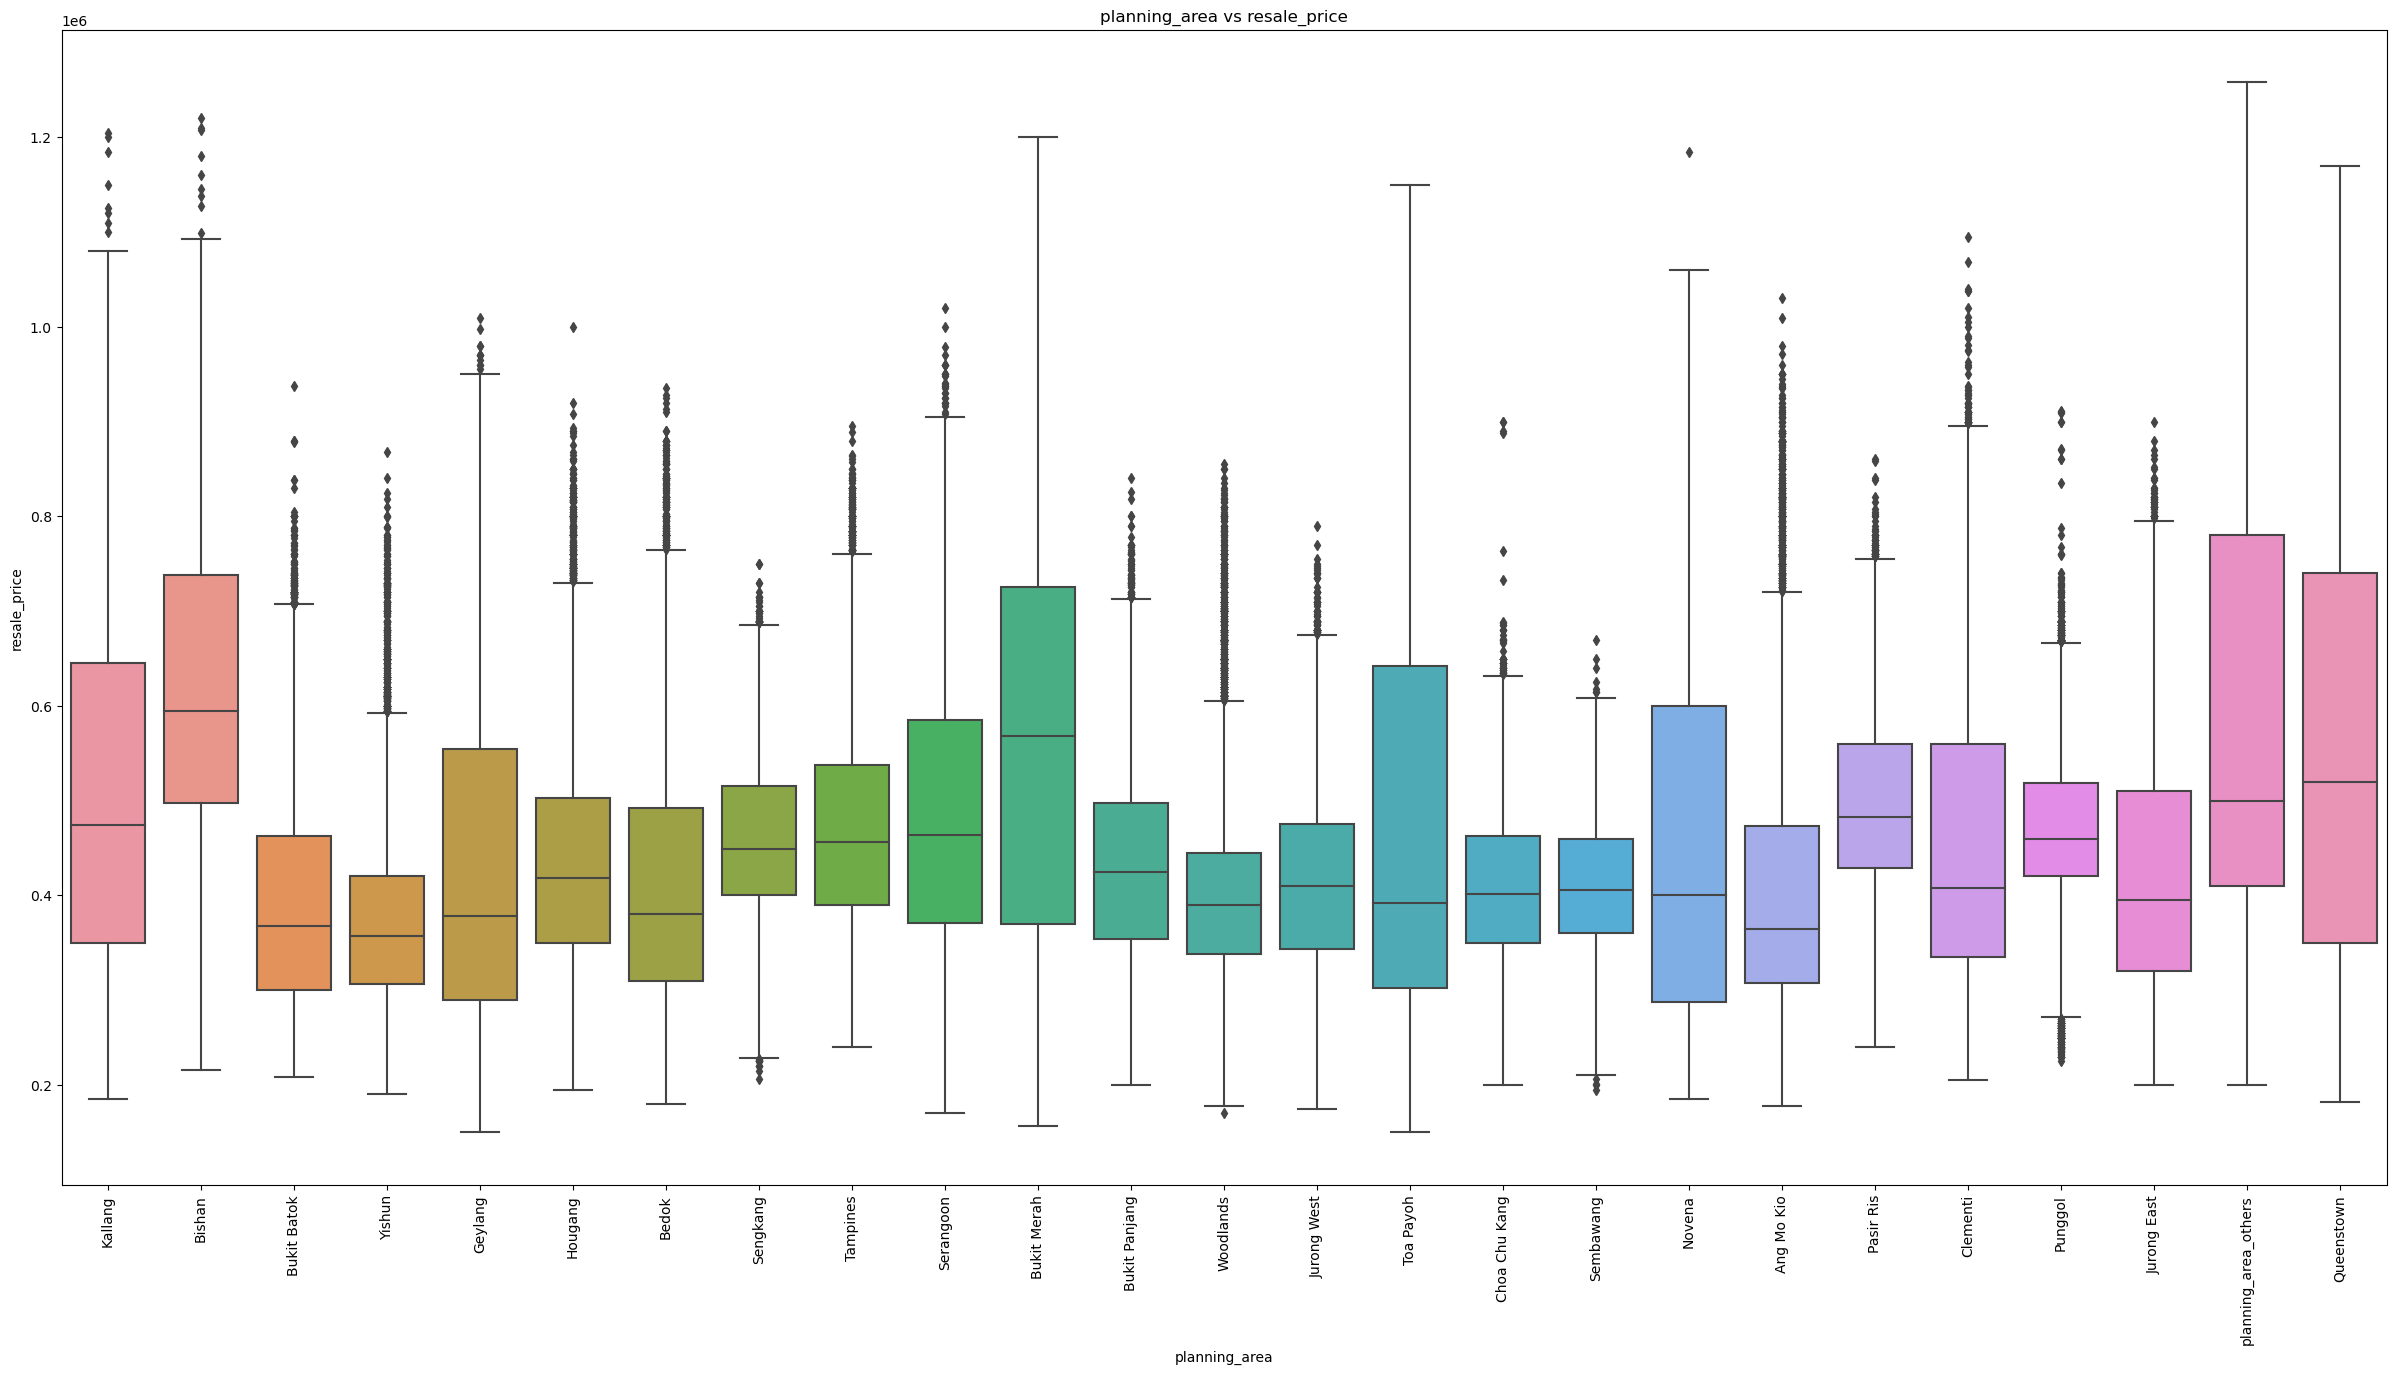

In [69]:
def boxplot(df):
        plt.figure(figsize=(30, 15))
        sns.boxplot(data=train, x='planning_area', y="resale_price")
        plt.xticks(rotation=90)  # Set the x-axis text to be vertical
        plt.title("planning_area vs resale_price")
        plt.show()
    
boxplot(train)

---
**Observations: <br>**
Charts above were hard to read , and there seems to be many outliers per planning area.<br>
Perhaps try mapping district numbers to planning area as a form of feature engineering

---
#### Exploring planning areas by district numbers

First, a list of district numbers to planning areas was found online.
I then used the information to create dictionary of district numbers to planning areas:

In [70]:
# Create dictionary of district numbers
district_nos = {
    1 : ['Raffles Place', 'Cecil', 'Marina', 'People’s Park'],
    2 : ['Anson', 'Tanjong Pagar'],
    3 : ['Queenstown', 'Tiong Bahru', 'Alexandra'],
    4 : ['Telok Blangah', 'Harbourfront', 'Sentosa', 'Keppel', 'Mount Faber'],
    5 : ['Pasir Panjang', 'Buona Vista', 'Dover', 'West Coast', 'Clementi New Town'],
    6 : ['High Street', 'Beach Road', 'City Hall'],
    7 : ['Middle Road', 'Golden Mile', 'Bugis', 'Rochor'],
    8 : ['Little India', 'Farrer Park', 'Serangoon Road'],
    9 : ['Orchard', 'Cairnhill', 'River Valley'],
    10 : ['Ardmore', 'Bukit Timah', 'Holland Road', 'Tanglin'],
    11 : ['Watten Estate', 'Newton', 'Novena', 'Thomson'],
    12 : ['Balestier', 'Toa Payoh', 'Serangoon'],
    13 : ['Macpherson', 'Braddell', 'Potong Pasir'],
    14 : ['Geylang', 'Paya Lebar', 'Eunos', 'Kembangan'],
    15 : ['Katong', 'Joo Chiat', 'Amber Road', 'Marine Parade', 'Tanjong Rhu', 'Meyer'],
    16 : ['Bedok', 'Upper East Coast', 'Eastwood', 'Kew Drive', 'Chai Chee', 'Siglap'],
    17 : ['Loyang', 'Changi'],
    18 : ['Tampines', 'Pasir Ris', 'Simei'],
    19 : ['Serangoon Garden', 'Hougang', 'Punggol', 'Sengkang'],
    20 : ['Bishan', 'Ang Mo Kio', 'Braddell'],
    21 : ['Upper Bukit Timah', 'Ulu Pandan'],
    22 : ['Jurong', 'Boon Lay', 'Tuas', 'Lakeside'],
    23 : ['Hillview', 'Dairy Farm', 'Bukit Panjang', 'Choa Chu Kang', 'Bukit Batok'],
    24 : ['Lim Chu Kang'],
    25 : ['Kranji', 'Woodgrove', 'Woodlands'],
    26 : ['Upper Thomson', 'Springleaf'],
    27 : ['Yishun', 'Sembawang', 'Admiralty'],
    28 : ['Seletar', 'Yio Chu Kang']}

Noticed some of my planning areas cannot be found in the dictionary. Find which areas are these:

In [73]:
total_district_areas = []

for area in district_nos.values():
    total_district_areas.extend(area)

In [74]:
#List of planning areas in my dataframe
planning_area = train_og['planning_area'].unique().tolist()

#Use a loop to check which areas are not in the district dictionary
not_found_areas = []  

for area in planning_area:
    if area not in total_district_areas:
        not_found_areas.append(area)

print("Values not found in the dictionary:", not_found_areas)

Values not found in the dictionary: ['Kallang', 'Bukit Merah', 'Jurong West', 'Clementi', 'Jurong East', 'Outram', 'Western Water Catchment', 'Downtown Core']


To avoid loss of information, and since there are not too many values missed out, i decided to manually append these values into the dictionary according to the districts they are located at:

In [75]:
district_nos = {
    1 : ['Raffles Place', 'Cecil', 'Marina', 'People’s Park'],
    2 : ['Anson', 'Tanjong Pagar', 'Downtown Core', 'Outram'],
    3 : ['Queenstown', 'Tiong Bahru', 'Alexandra', 'Bukit Merah'],
    4 : ['Telok Blangah', 'Harbourfront', 'Sentosa', 'Keppel', 'Mount Faber'],
    5 : ['Pasir Panjang', 'Buona Vista', 'Dover', 'West Coast', 'Clementi New Town'],
    6 : ['High Street', 'Beach Road', 'City Hall'],
    7 : ['Middle Road', 'Golden Mile', 'Bugis', 'Rochor'],
    8 : ['Little India', 'Farrer Park', 'Serangoon Road'],
    9 : ['Orchard', 'Cairnhill', 'River Valley'],
    10 : ['Ardmore', 'Bukit Timah', 'Holland Road', 'Tanglin'],
    11 : ['Watten Estate', 'Newton', 'Novena', 'Thomson'],
    12 : ['Balestier', 'Toa Payoh', 'Serangoon'],
    13 : ['Macpherson', 'Braddell', 'Potong Pasir'],
    14 : ['Geylang', 'Paya Lebar', 'Eunos', 'Kembangan'],
    15 : ['Katong', 'Joo Chiat', 'Amber Road', 'Marine Parade', 'Tanjong Rhu', 'Meyer', 'Kallang'],
    16 : ['Bedok', 'Upper East Coast', 'Eastwood', 'Kew Drive', 'Chai Chee', 'Siglap'],
    17 : ['Loyang', 'Changi'],
    18 : ['Tampines', 'Pasir Ris', 'Simei'],
    19 : ['Serangoon Garden', 'Hougang', 'Punggol', 'Sengkang'],
    20 : ['Bishan', 'Ang Mo Kio', 'Braddell'],
    21 : ['Upper Bukit Timah', 'Ulu Pandan'],
    22 : ['Jurong', 'Boon Lay', 'Tuas', 'Lakeside', 'Jurong East', 'Jurong West', 'Clementi'],
    23 : ['Hillview', 'Dairy Farm', 'Bukit Panjang', 'Choa Chu Kang', 'Bukit Batok', 'Western Water Catchment'],
    24 : ['Lim Chu Kang'],
    25 : ['Kranji', 'Woodgrove', 'Woodlands'],
    26 : ['Upper Thomson', 'Springleaf'],
    27 : ['Yishun', 'Sembawang', 'Admiralty'],
    28 : ['Seletar', 'Yio Chu Kang']}

---
Feature engineering - Create a new column with district numbers:

In [79]:
#create function to convert planning area to district
def convert_district(area):
    for key in district_nos.keys():
        if area in district_nos[key]:
            return key

In [80]:
train_og['district'] = train_og['planning_area'].apply(convert_district)

In [81]:
train_og.head()

id tranc_yearmonth             town  flat_type block       street_name  \
0   88471      2016-05-01  KALLANG/WHAMPOA     4 ROOM    3B  UPP BOON KENG RD   
1  122598      2012-07-01           BISHAN     5 ROOM   153      BISHAN ST 13   
2  170897      2013-07-01      BUKIT BATOK  EXECUTIVE  289B    BT BATOK ST 25   
3   86070      2012-04-01           BISHAN     4 ROOM   232      BISHAN ST 22   
4  153632      2017-12-01           YISHUN     4 ROOM   876      YISHUN ST 81   

  storey_range  floor_area_sqm  flat_model  lease_commence_date  ...  \
0     10 TO 12           90.00     Model A                 2006  ...   
1     07 TO 09          130.00    Improved                 1987  ...   
2     13 TO 15          144.00   Apartment                 1997  ...   
3     01 TO 05          103.00     Model A                 1992  ...   
4     01 TO 03           83.00  Simplified                 1987  ...   

   pri_sch_affiliation  pri_sch_latitude  pri_sch_longitude  \
0                    1              1.32             103.88   
1                    1              1.35             103.85   
2                    0              1.35             103.76   
3                    1              1.35             103.84   
4                    0              1.42             103.84   

   sec_sch_nearest_dist                             sec_sch_name  \
0               1138.63                 Geylang Methodist School   
1                447.89  Kuo Chuan Presbyterian Secondary School   
2                180.07             Yusof Ishak Secondary School   
3                389.52                     Catholic High School   
4                312.03             Orchid Park Secondary School   

   cutoff_point  affiliation sec_sch_latitude sec_sch_longitude  district  
0           224            0             1.32            103.88        15  
1           232            0             1.35            103.85        20  
2           188            0             1.34            103.76        23  
3           253            1             1.35            103.84        20  
4           208            0             1.41            103.84        27  

[5 rows x 78 columns]

---
replot graphs according to districts

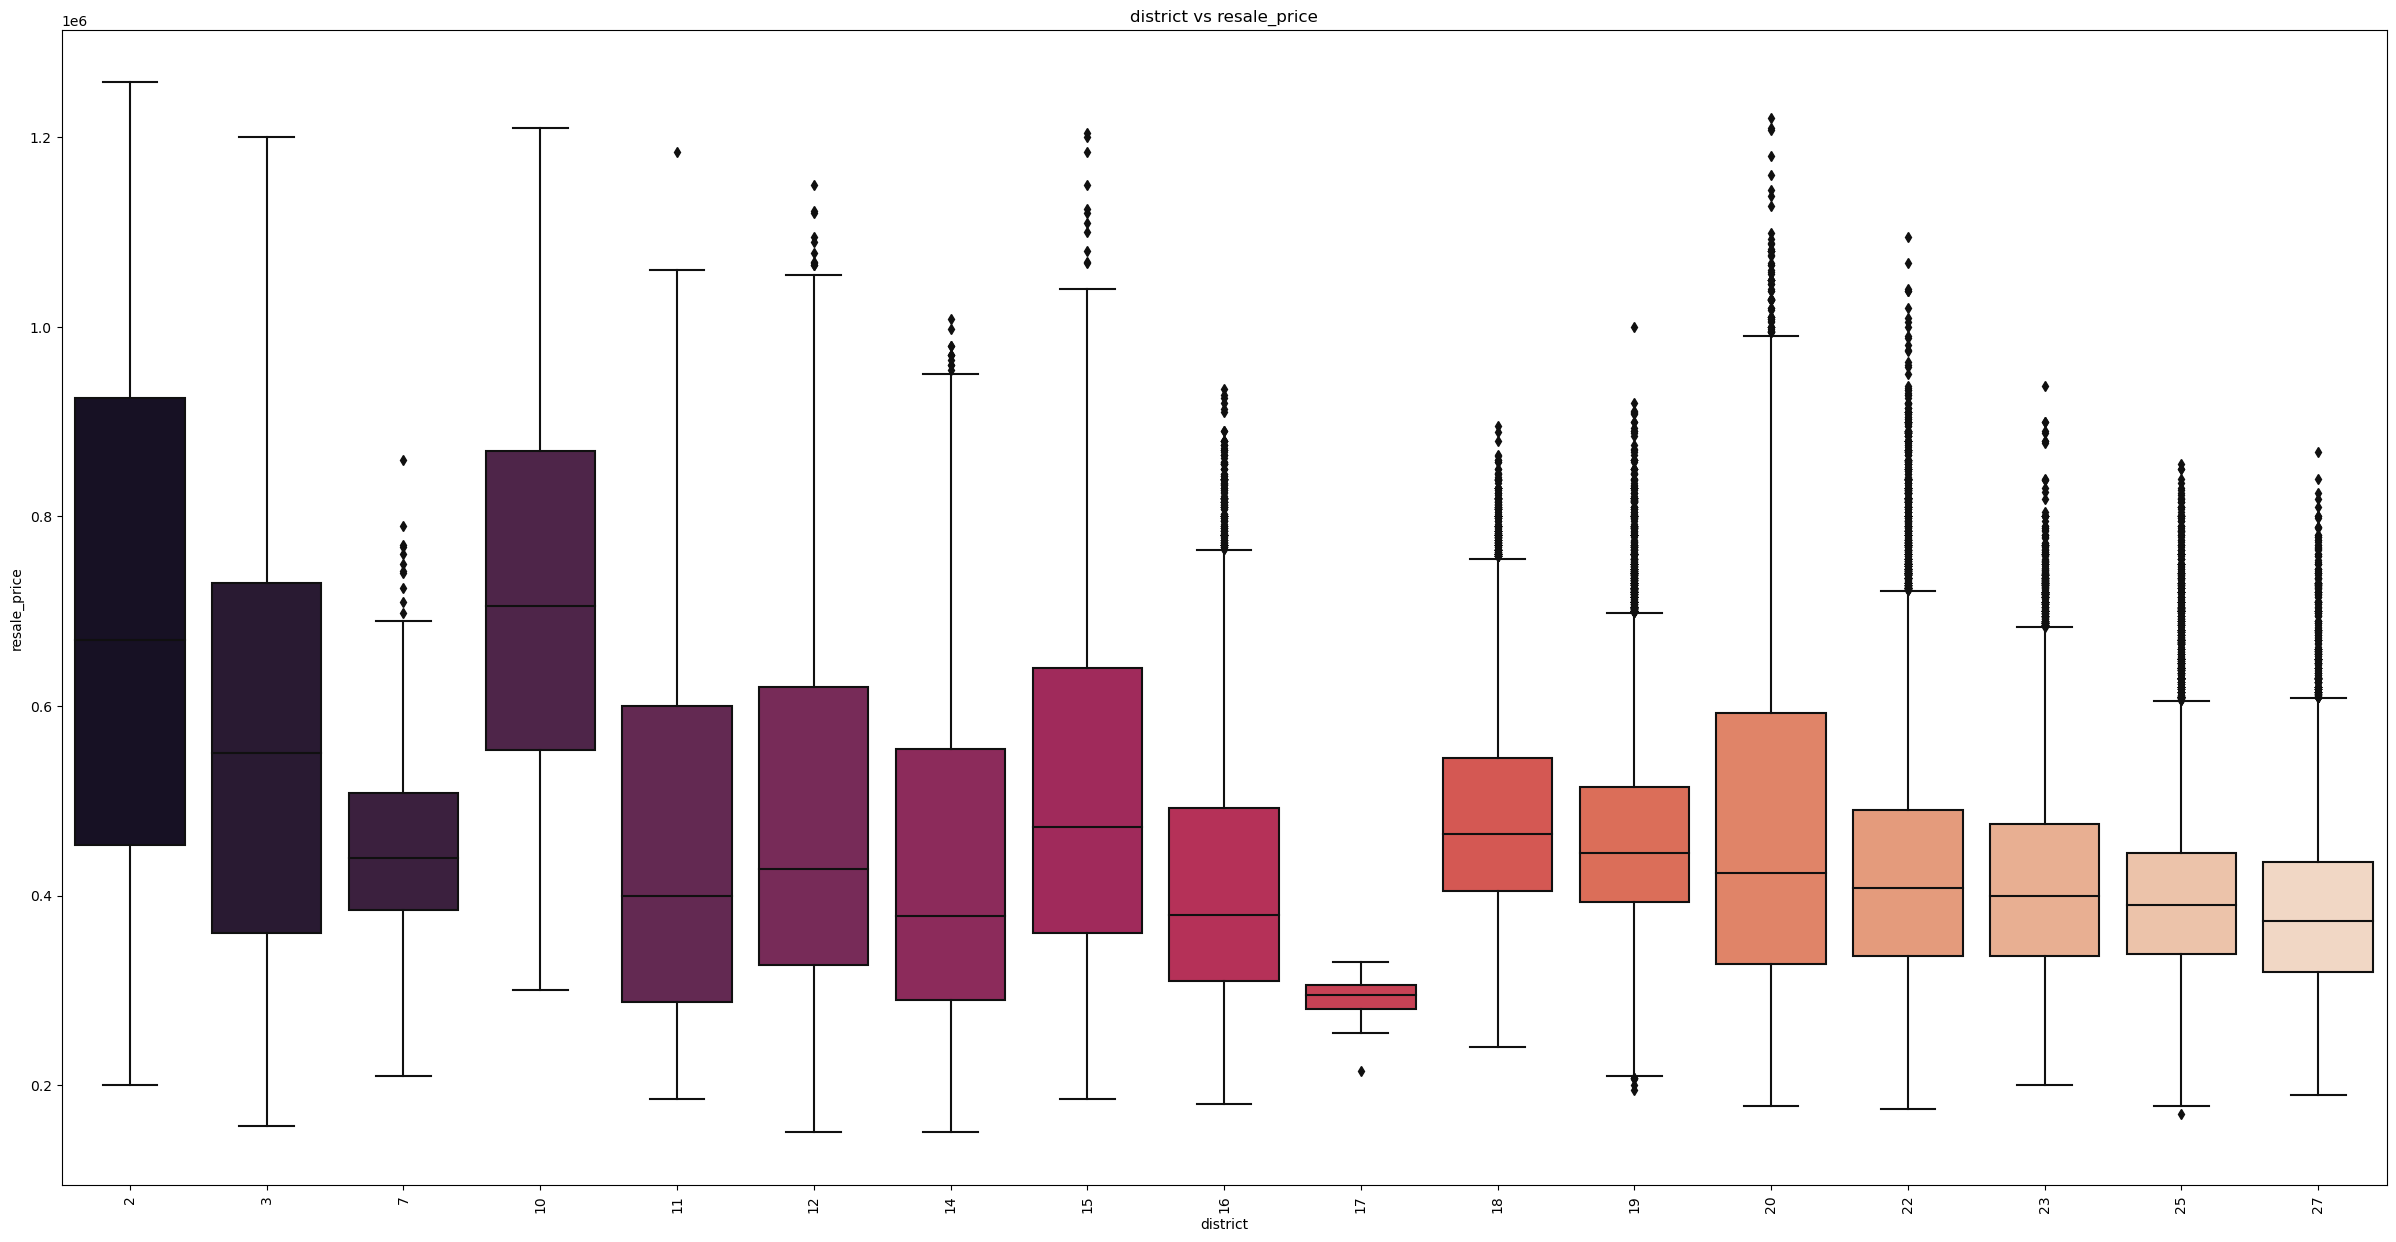

In [82]:
def boxplot(df):
        plt.figure(figsize=(30, 15))
        sns.boxplot(data=train_og, x='district', y="resale_price", palette='rocket')
        plt.xticks(rotation=90)  # Set the x-axis text to be vertical
        plt.title("district vs resale_price")
        plt.show()
    
boxplot(train)

**Observation:<br>**
From this boxplot, we can see that the districts with highest median resale price is district 2 and district 10. 
Districts with the lowest median price is district 17 and 27.

Also, replotting the boxplot by districts managed to reduce the outliers to some extent.


---

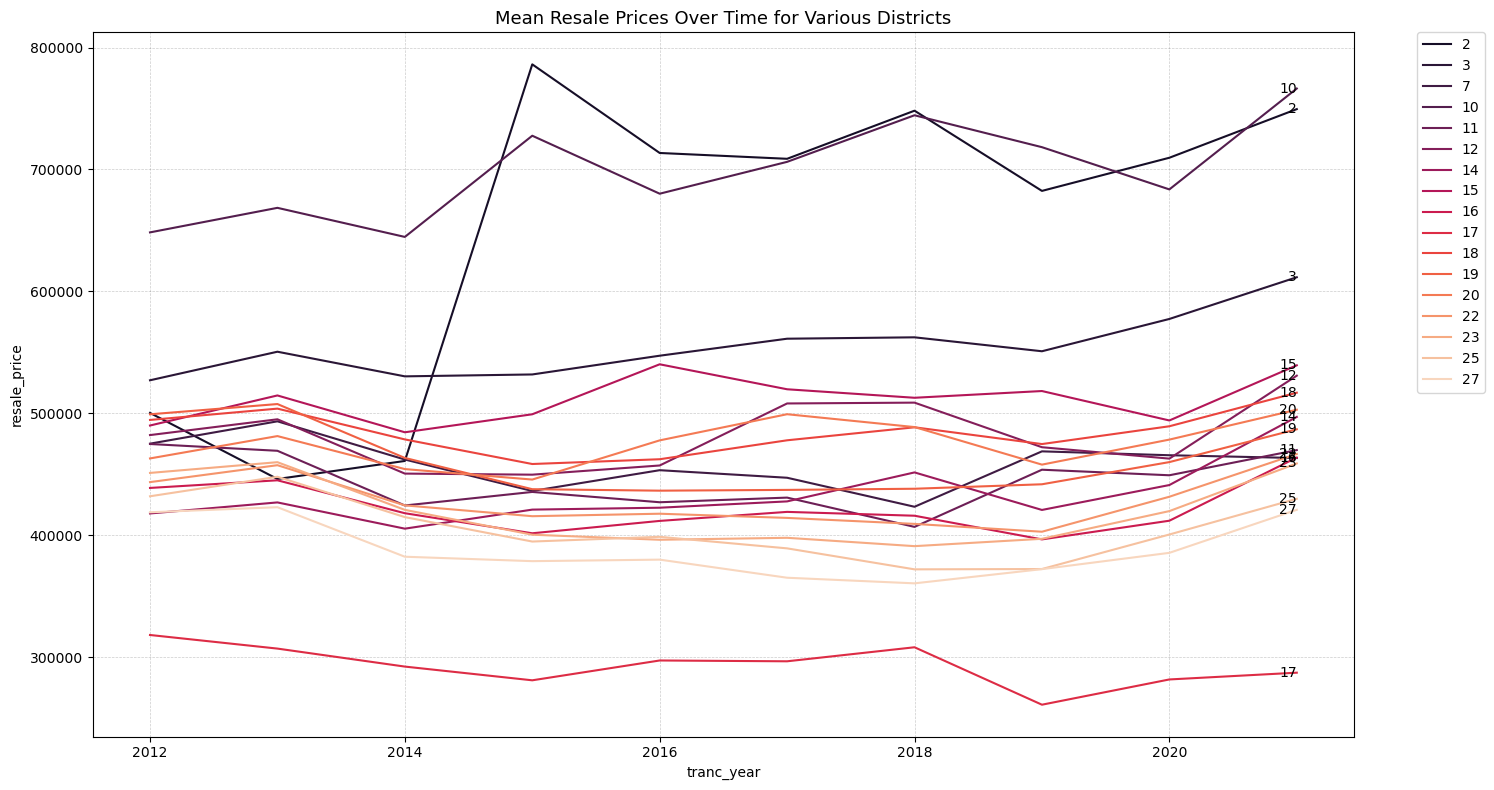

In [84]:
# Group the data by 'district' and 'year' and calculate the mean resale prices for each group
mean_prices = train_og.groupby(['district', 'tranc_year'])['resale_price'].mean().reset_index()

# Establish the size of the figure.
plt.figure(figsize=(15, 8))

# Define colour palette
custom_palette = sns.color_palette("rocket", n_colors=len(mean_prices['district'].unique()))

# Plot the mean resale prices over time for various planning areas without markers
sns.lineplot(x='tranc_year', y='resale_price', hue='district', data=mean_prices, palette=custom_palette, markers=False, err_style=None)

# Create a grid in the background.
plt.grid(True, linewidth=0.5, linestyle='--', c='black', alpha=0.2)

# Create tick mark labels on the X, Y axis without rotating them.
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Create title.
plt.title("Mean Resale Prices Over Time for Various Districts", fontsize=13)

# Move the legend outside the plot area to avoid overlapping with the lines
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Label the district numbers
for district, group_data in mean_prices.groupby('district'):
    last_data = group_data.iloc[-1]
    plt.text(last_data['tranc_year'], last_data['resale_price'], district, fontsize=10, ha='right', va='center')


# Show the plot
plt.tight_layout()
plt.show()


From the final line graph, it is evident that districts of a smaller number (i.e. the more mature estates) seemingly command higher resale prices. 

---
### 2.1.2 Schools

Some potential aspects to explore:
* Categorise schools (what characteristics makes a school more attractive than others?)

In [22]:
train_sch = pickle.load(open('./pkl/train_clean.pkl', 'rb'))

In [23]:
train_sch.head(3)

id tranc_yearmonth             town  flat_type block       street_name  \
0   88471      2016-05-01  KALLANG/WHAMPOA     4 ROOM    3B  UPP BOON KENG RD   
1  122598      2012-07-01           BISHAN     5 ROOM   153      BISHAN ST 13   
2  170897      2013-07-01      BUKIT BATOK  EXECUTIVE  289B    BT BATOK ST 25   

  storey_range  floor_area_sqm flat_model  lease_commence_date  ...  vacancy  \
0     10 TO 12           90.00    Model A                 2006  ...       78   
1     07 TO 09          130.00   Improved                 1987  ...       45   
2     13 TO 15          144.00  Apartment                 1997  ...       39   

   pri_sch_affiliation  pri_sch_latitude  pri_sch_longitude  \
0                    1              1.32             103.88   
1                    1              1.35             103.85   
2                    0              1.35             103.76   

   sec_sch_nearest_dist                             sec_sch_name  \
0               1138.63                 Geylang Methodist School   
1                447.89  Kuo Chuan Presbyterian Secondary School   
2                180.07             Yusof Ishak Secondary School   

   cutoff_point affiliation sec_sch_latitude  sec_sch_longitude  
0           224           0             1.32             103.88  
1           232           0             1.35             103.85  
2           188           0             1.34             103.76  

[3 rows x 77 columns]

Create new dataframe extracting only sch related features:

In [24]:
train_sch = train_sch[['resale_price', 'pri_sch_name', 'vacancy', 'pri_sch_affiliation', 'sec_sch_name', 'cutoff_point', 'affiliation']]
train_sch.head()

resale_price                           pri_sch_name  vacancy  \
0     680000.00               Geylang Methodist School       78   
1     665000.00  Kuo Chuan Presbyterian Primary School       45   
2     838000.00                  Keming Primary School       39   
3     550000.00                   Catholic High School       20   
4     298000.00              Naval Base Primary School       74   

   pri_sch_affiliation                             sec_sch_name  cutoff_point  \
0                    1                 Geylang Methodist School           224   
1                    1  Kuo Chuan Presbyterian Secondary School           232   
2                    0             Yusof Ishak Secondary School           188   
3                    1                     Catholic High School           253   
4                    0             Orchid Park Secondary School           208   

   affiliation  
0            0  
1            0  
2            0  
3            1  
4            0

Explore primary school data / vacancies:

In [25]:
print(len(train_sch['pri_sch_name'].unique()))
train_sch['pri_sch_name'].unique()

177


array(['Geylang Methodist School',
       'Kuo Chuan Presbyterian Primary School', 'Keming Primary School',
       'Catholic High School', 'Naval Base Primary School',
       "Saint Margaret's Primary School", 'Xinmin Primary School',
       'Damai Primary School', 'Ai Tong School',
       'Anchor Green Primary School', 'North Vista Primary School',
       'Tampines North Primary School', 'Rosyth School',
       'Alexandra Primary School', 'Beacon Primary School',
       'Zhenghua Primary School', 'Fuchun Primary School',
       'Guangyang Primary School', 'Woodlands Ring Primary School',
       'Fernvale Primary School', 'Palm View Primary School',
       'Greenwood Primary School', 'Frontier Primary School',
       'Lakeside Primary School', 'Chua Chu Kang Primary School',
       'Wellington Primary School', 'Hong Wen School',
       'Compassvale Primary School', 'Kheng Cheng School',
       'Bendemeer Primary School', 'Unity Primary School',
       'Ang Mo Kio Primary School', 'Mars

Plot a bar chart of primary school vacancies:

In [26]:
pri_sch_names = train_sch['pri_sch_name'].tolist()
vacancy = train_sch['vacancy'].tolist()

---
## 2.2 Refinement of numerical selected features

In [30]:
train_num_sel = train.select_dtypes(include=['float64','int64'])

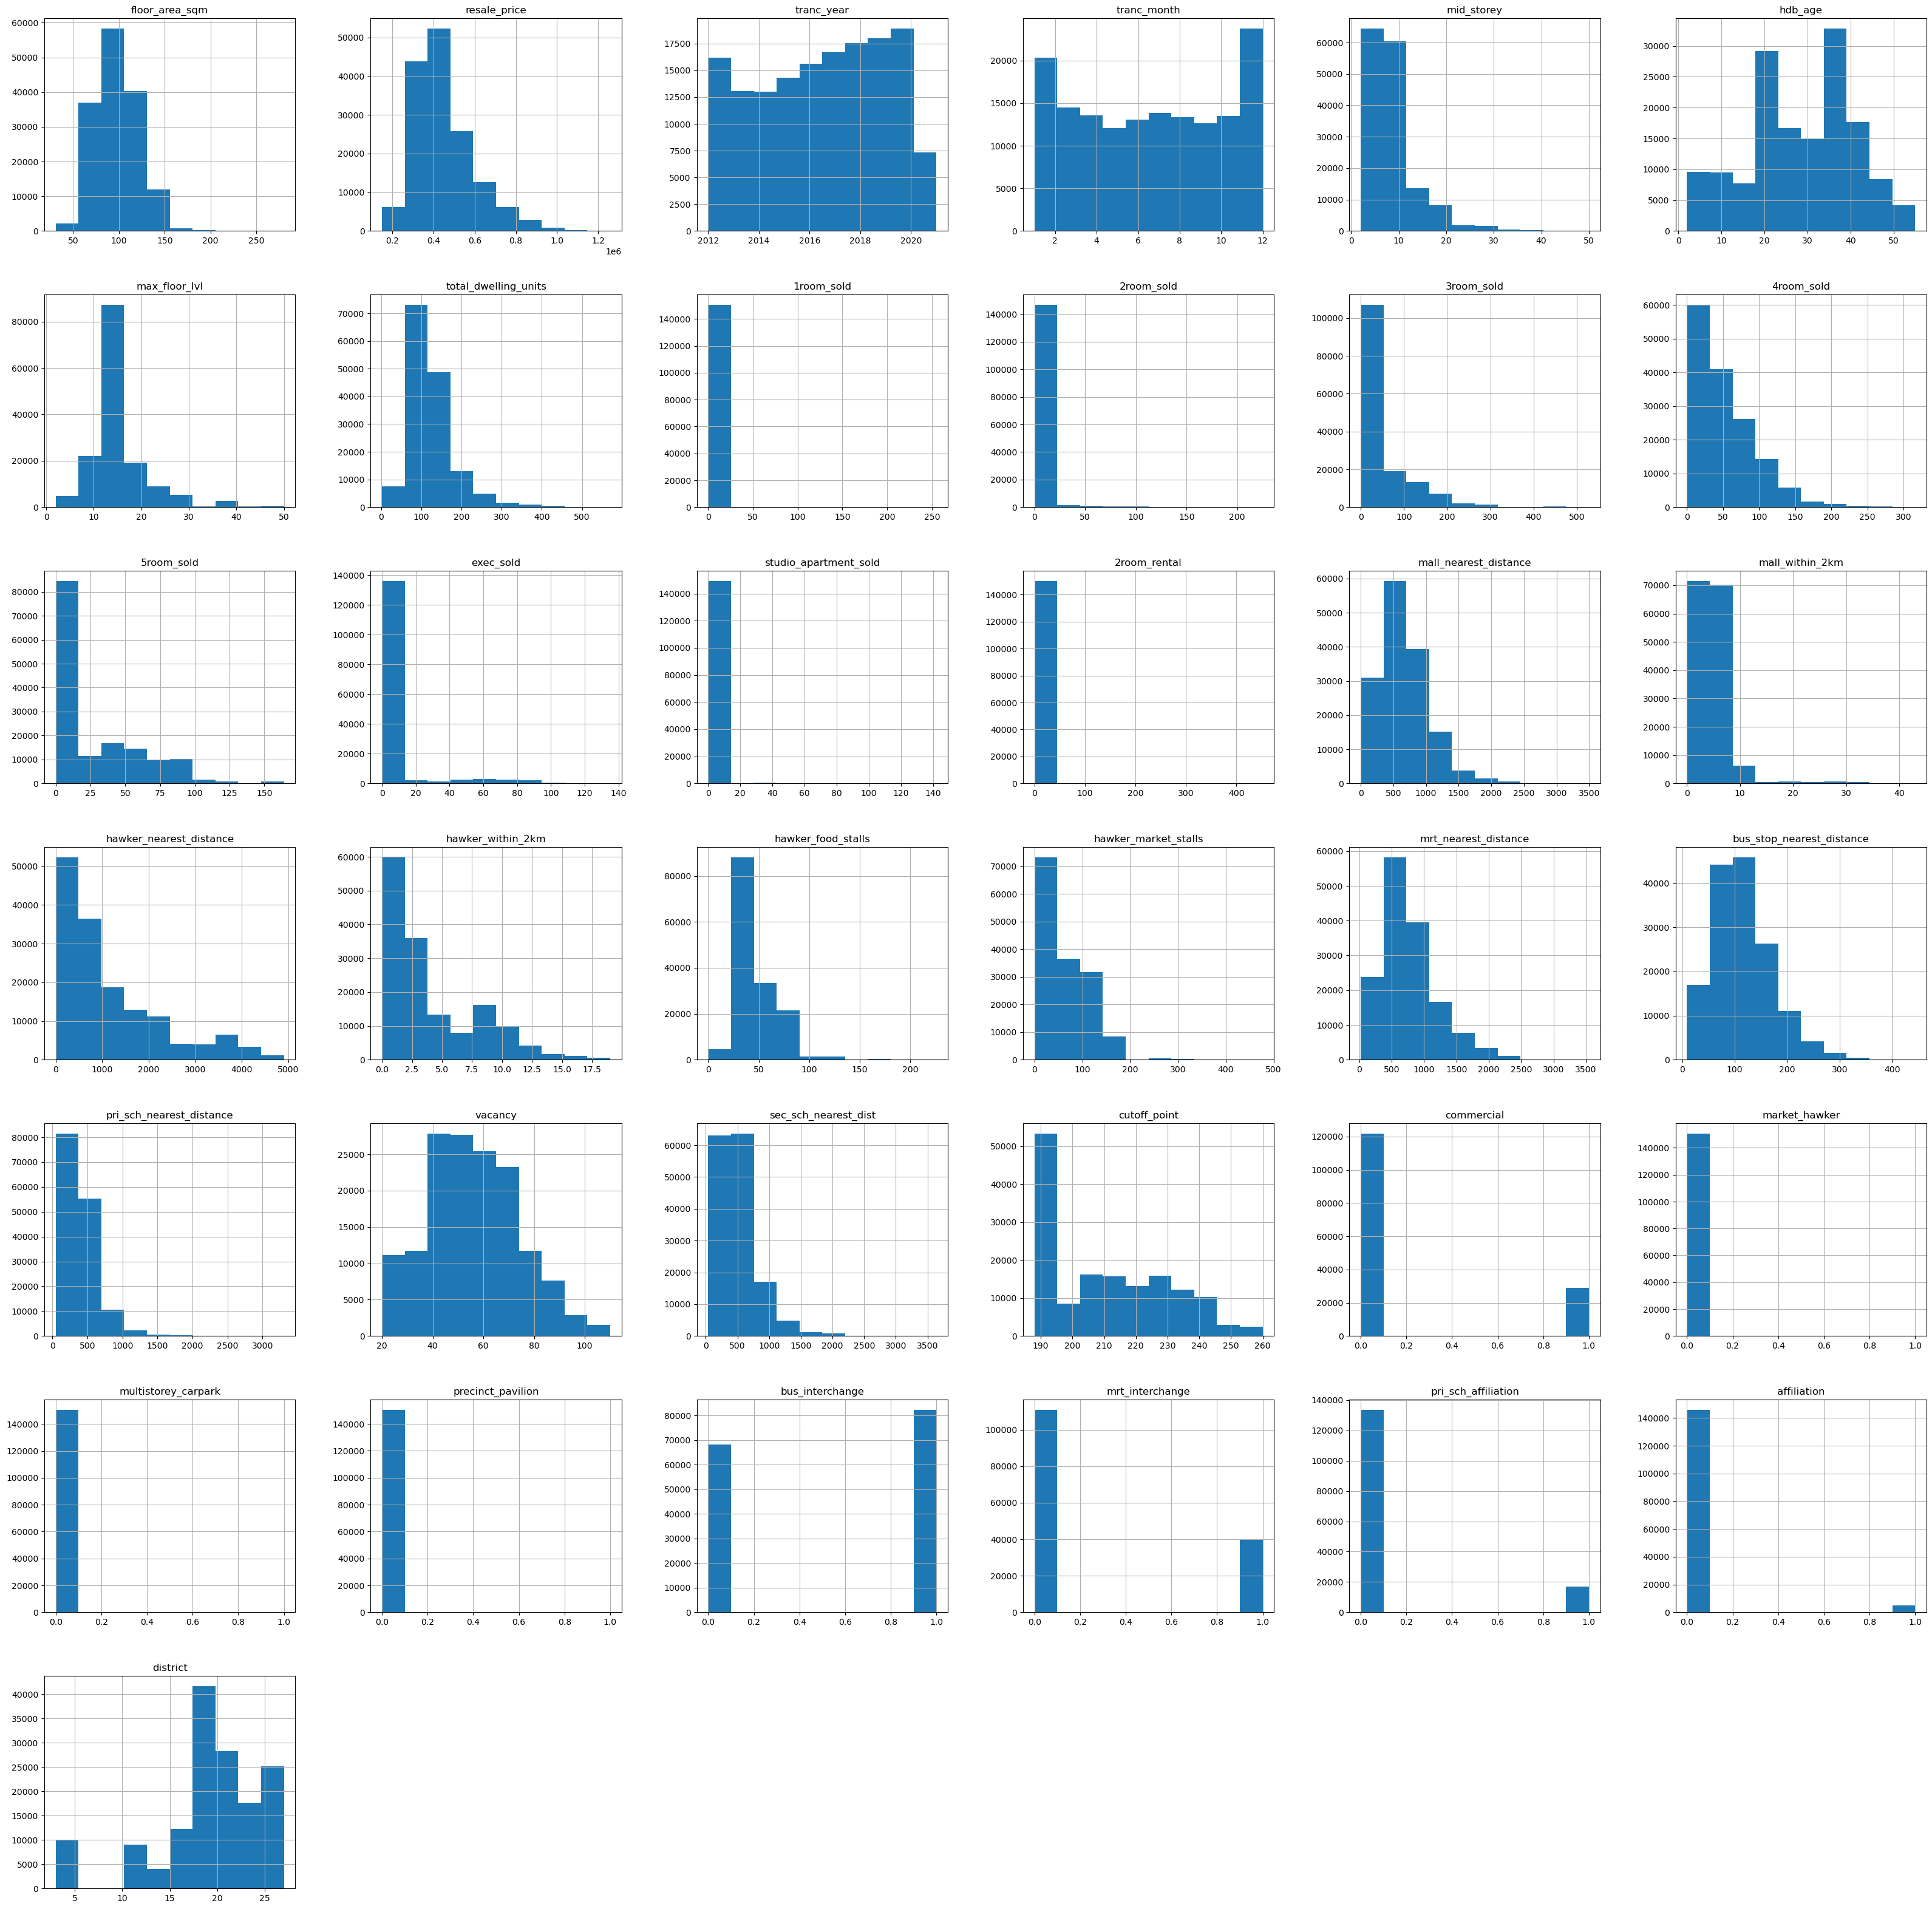

In [31]:
train_num_sel.hist(figsize=(40, 40));

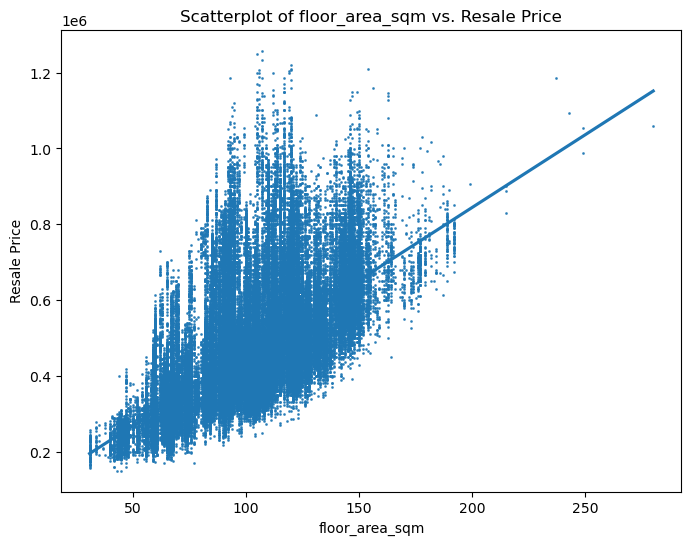

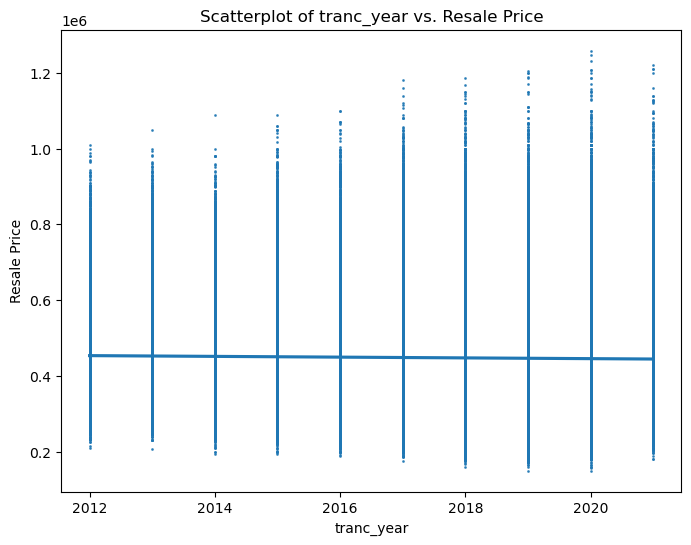

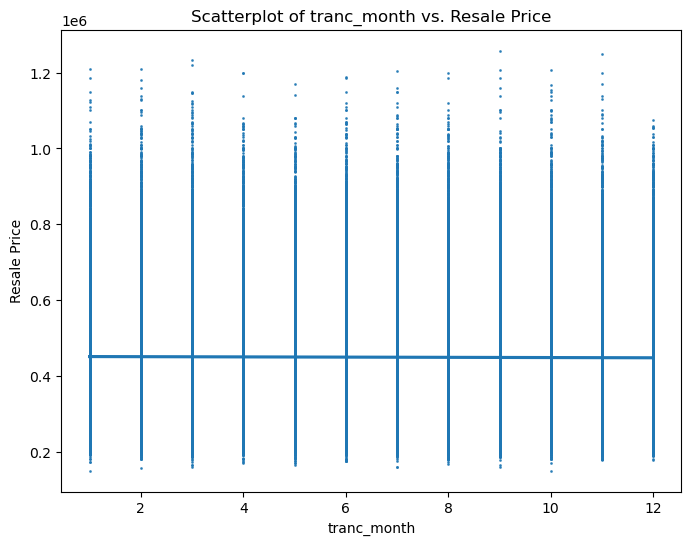

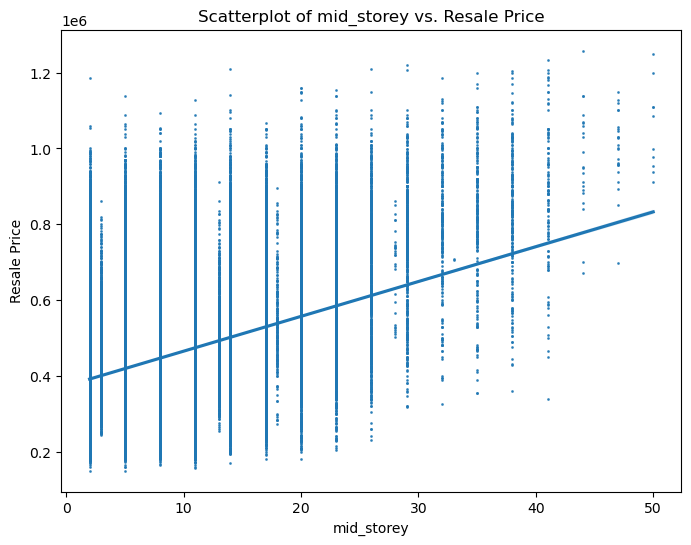

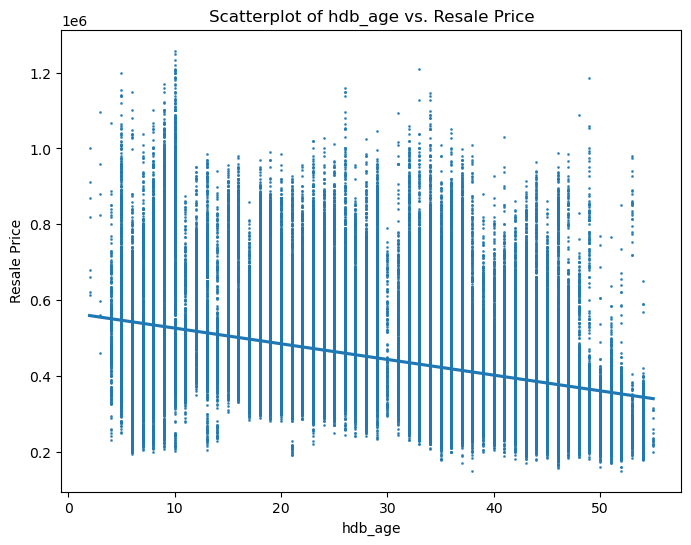

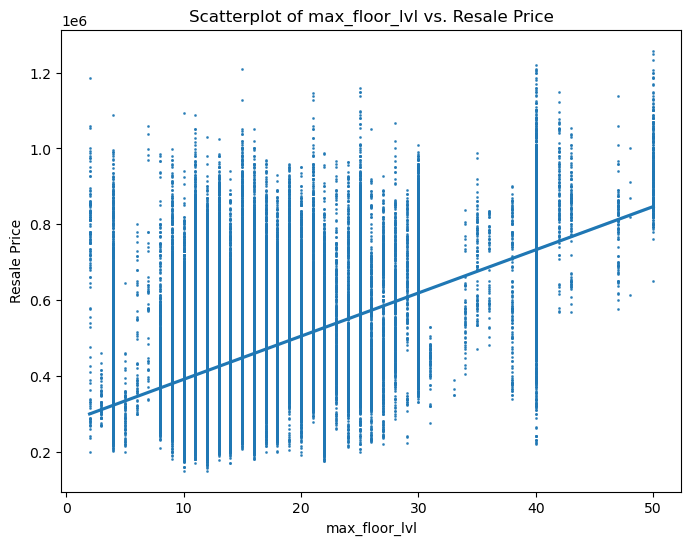

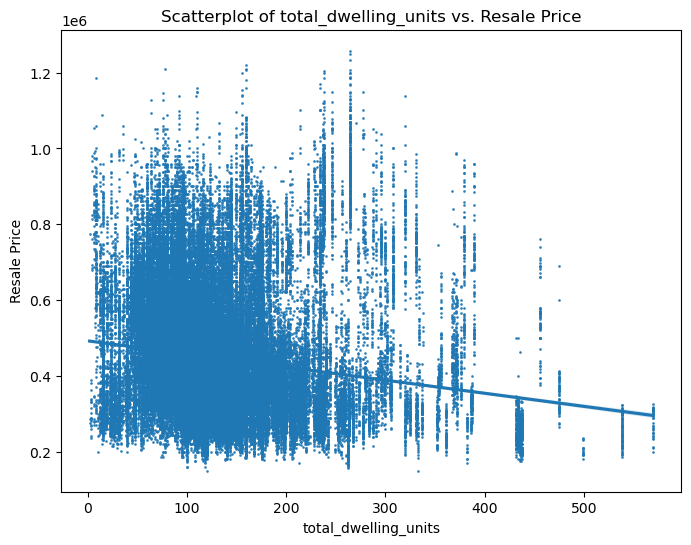

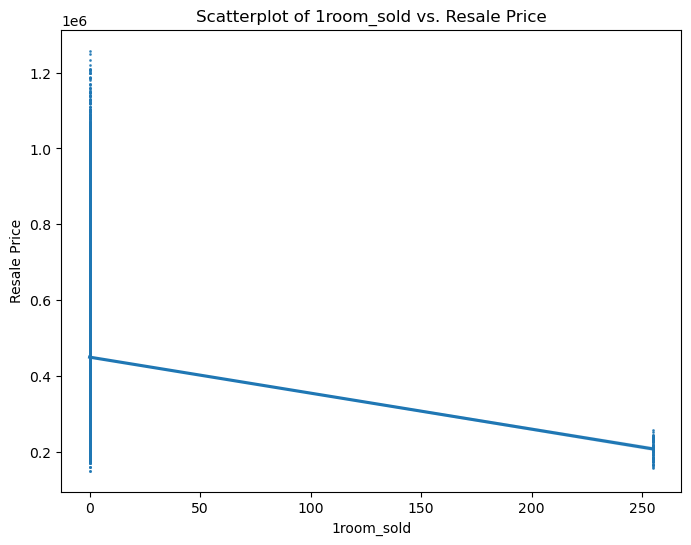

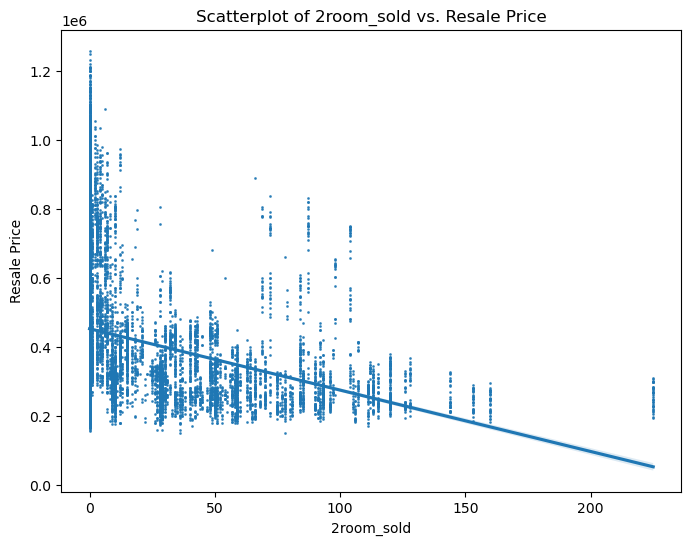

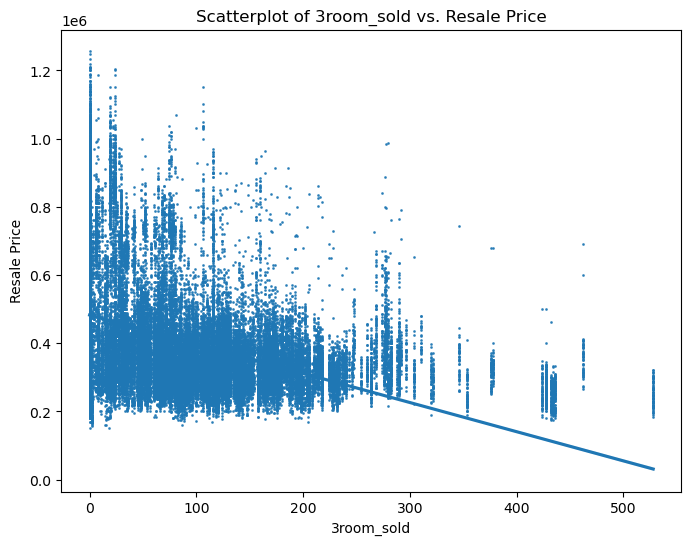

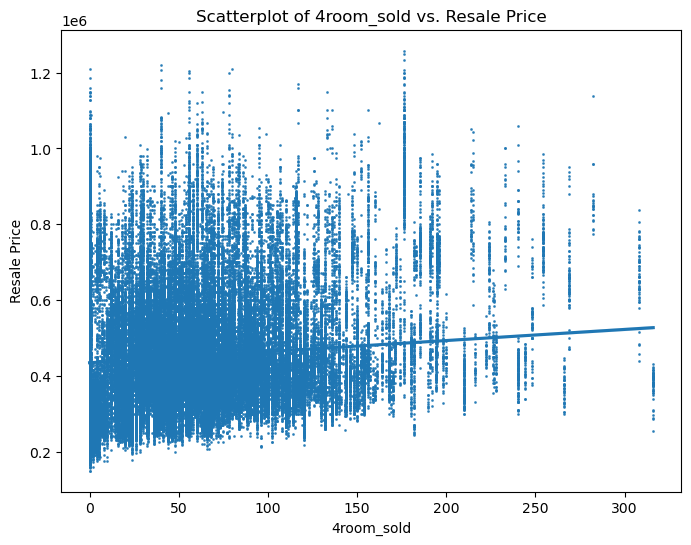

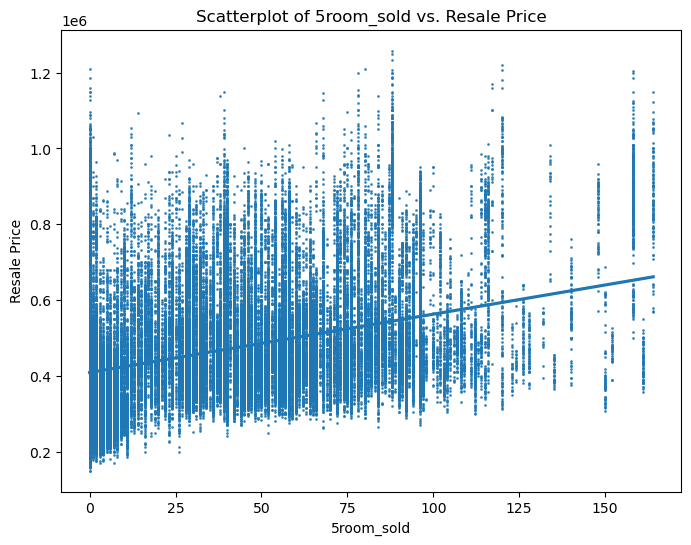

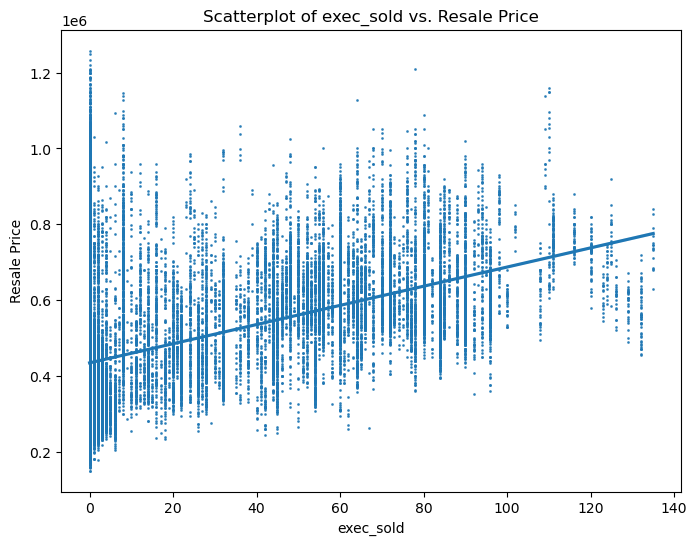

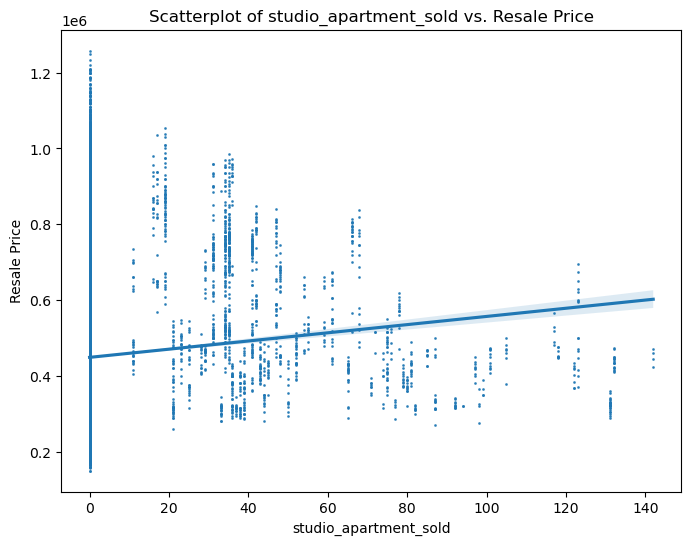

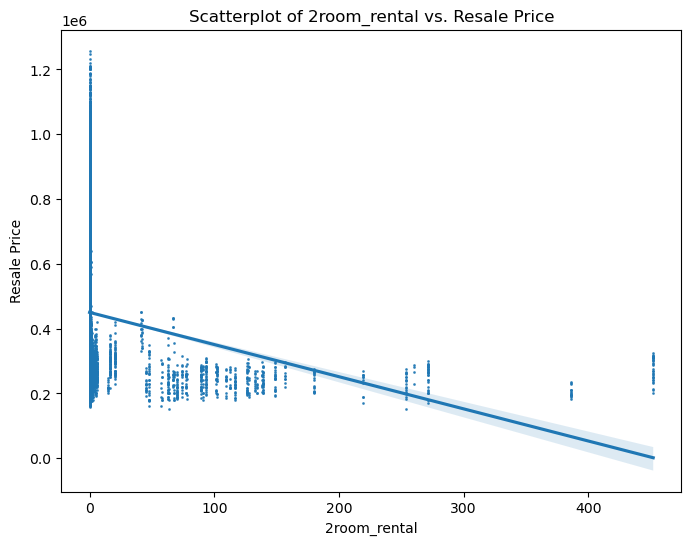

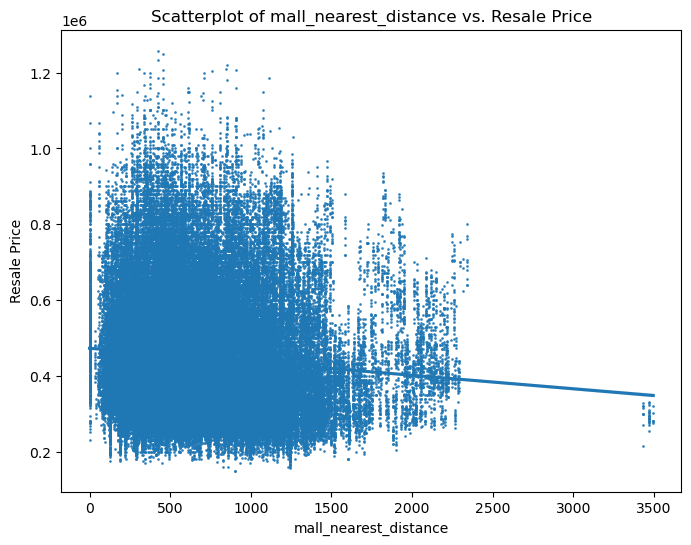

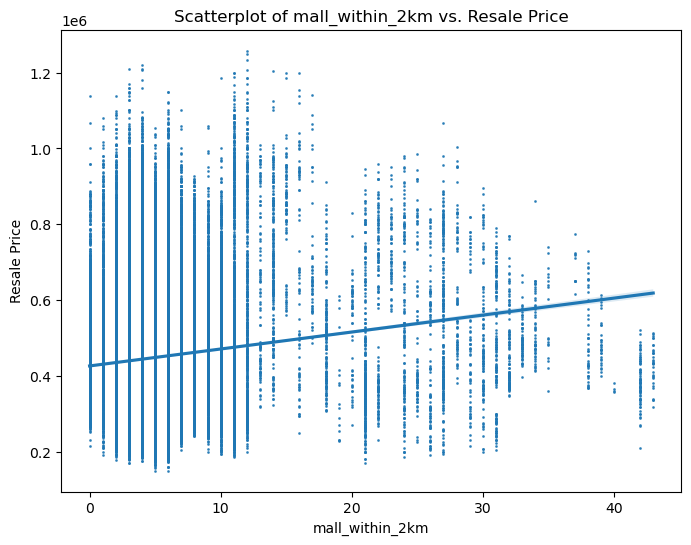

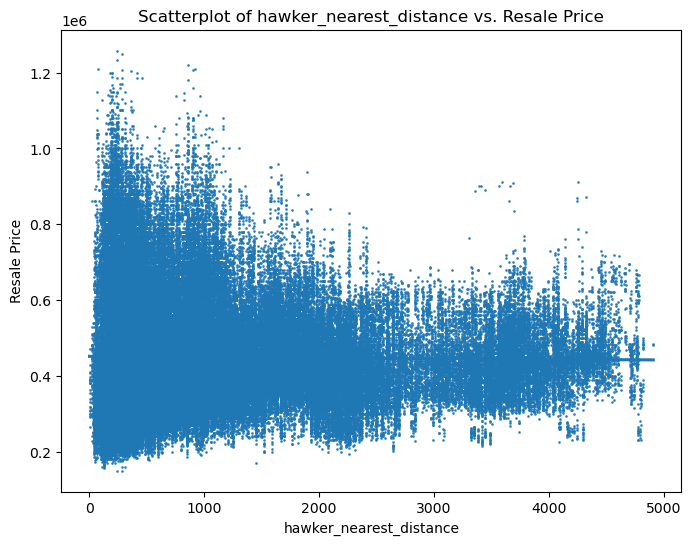

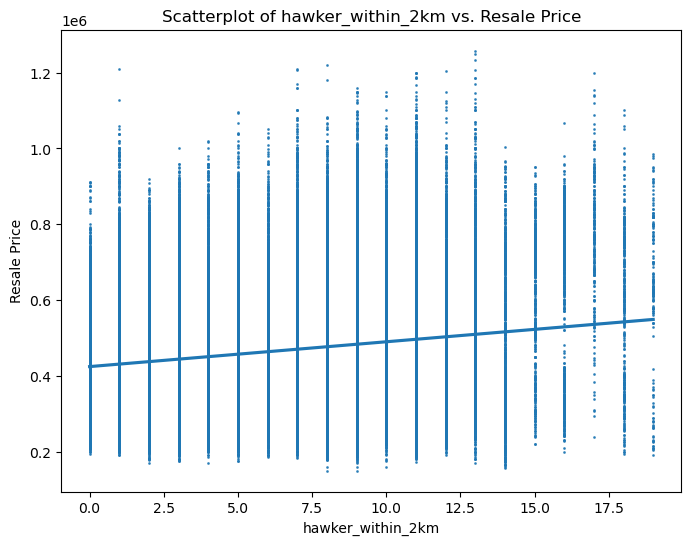

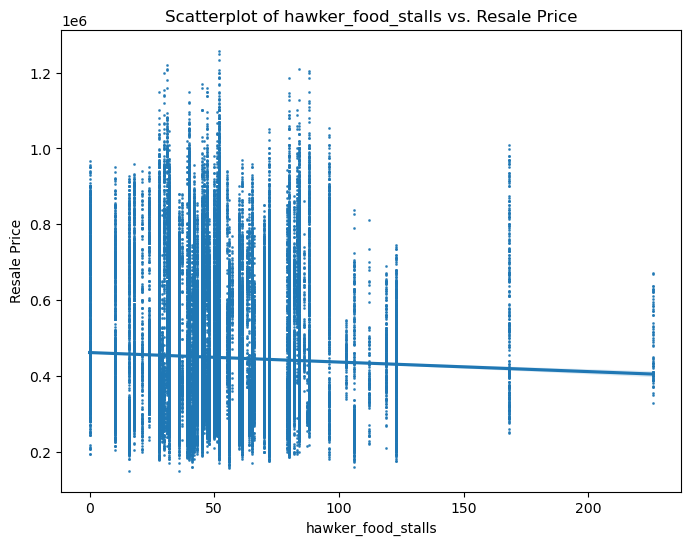

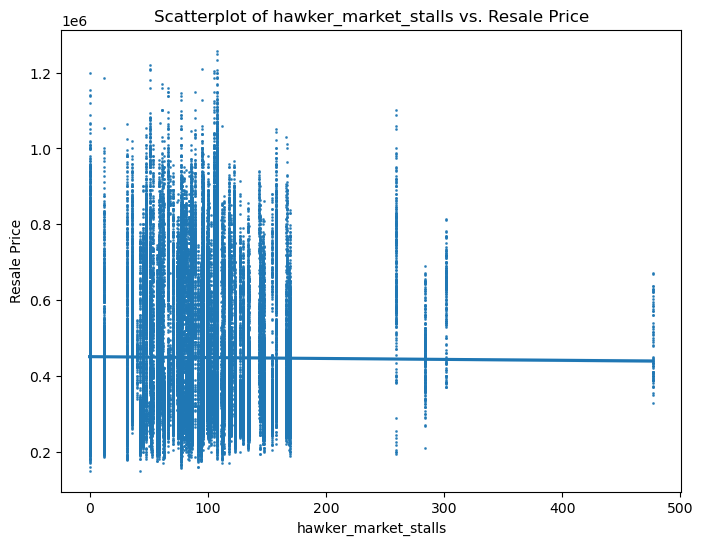

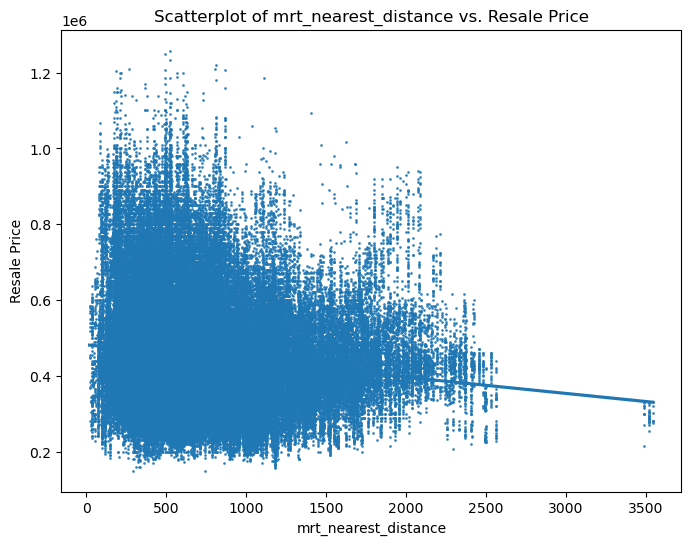

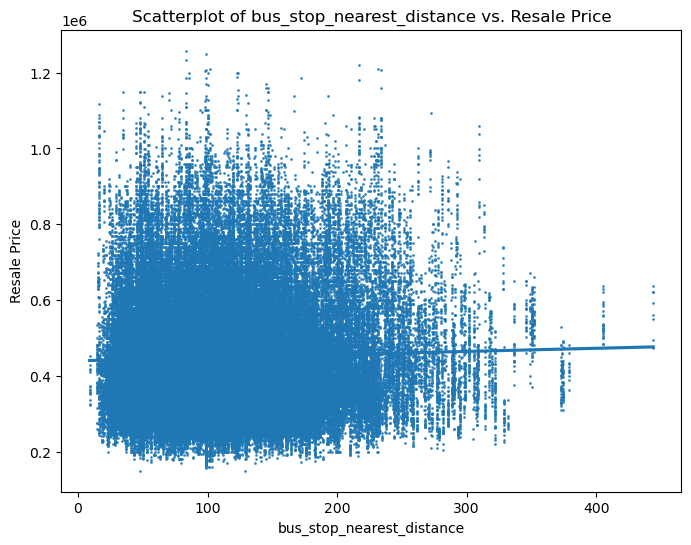

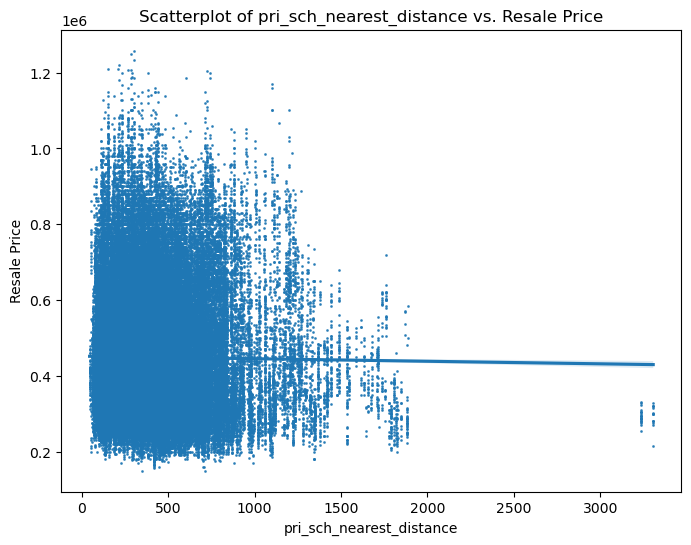

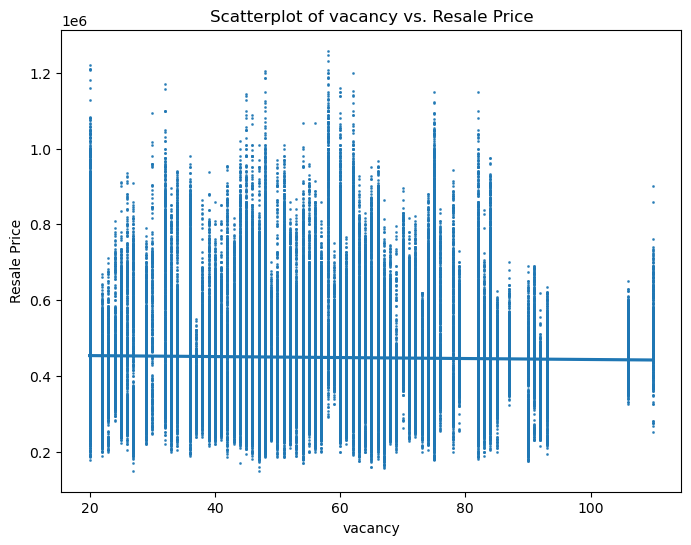

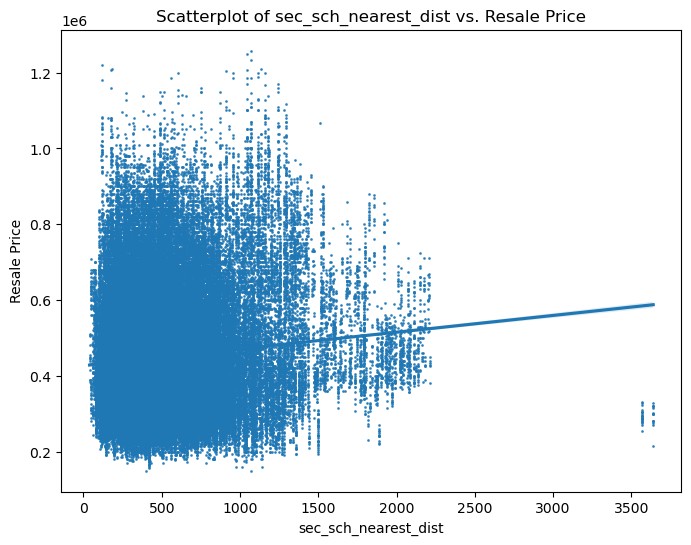

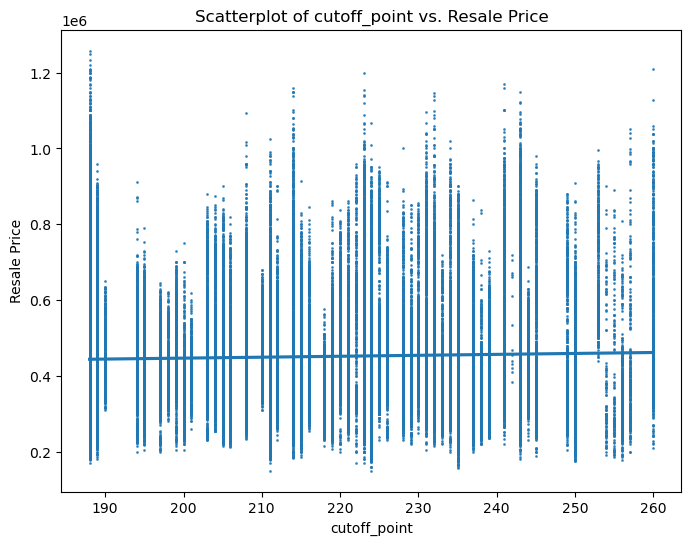

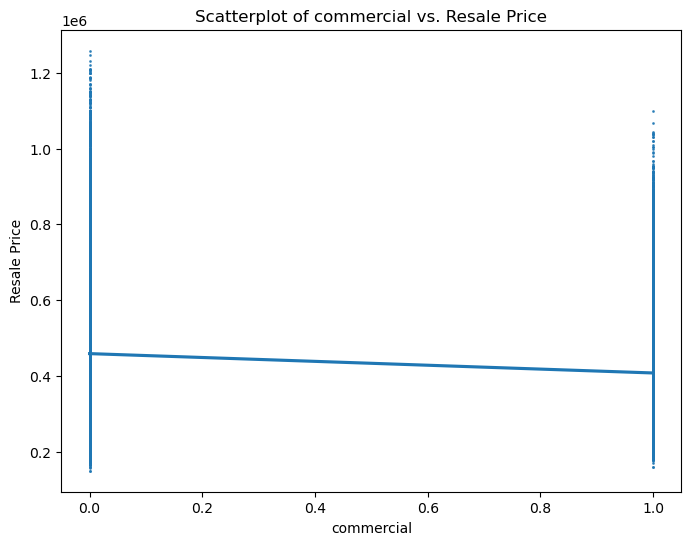

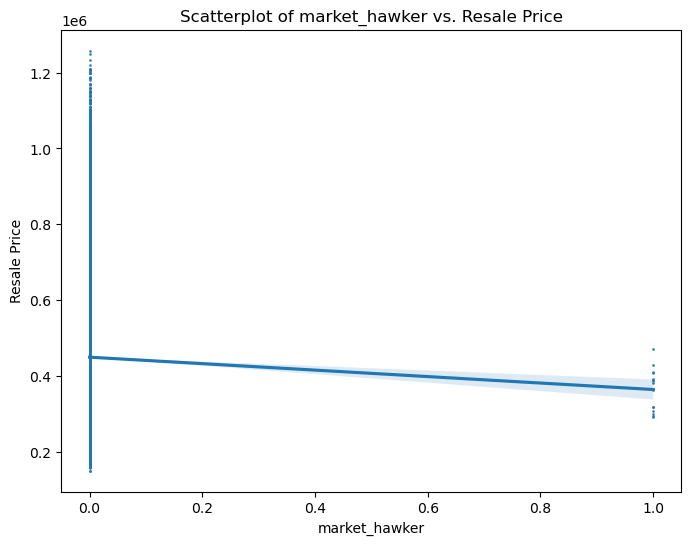

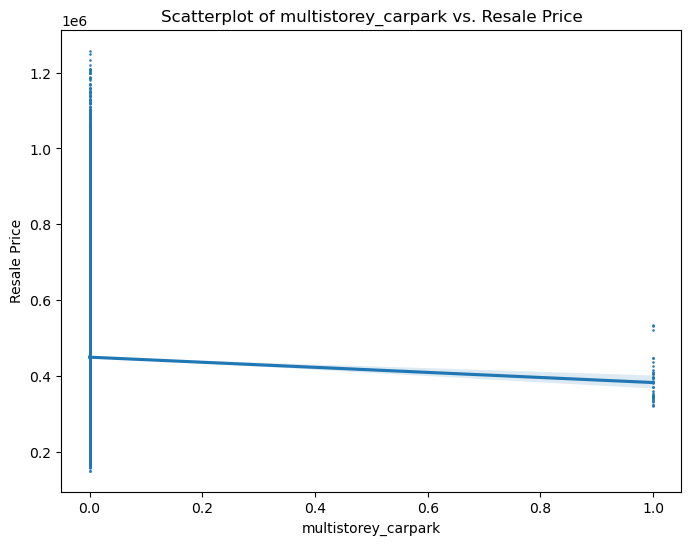

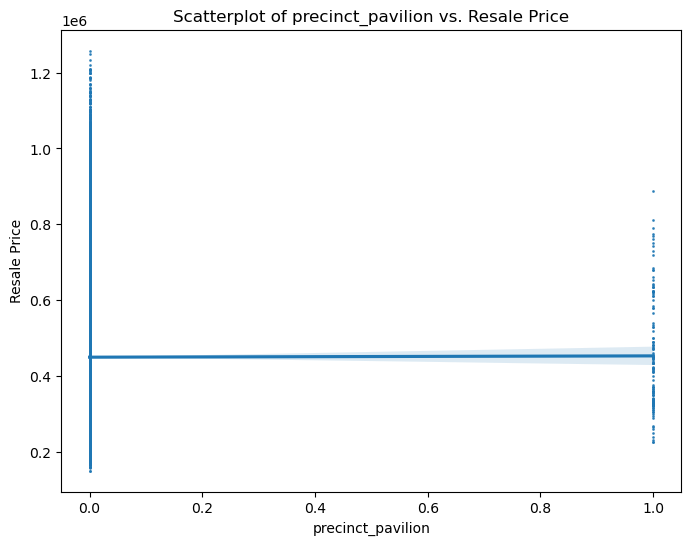

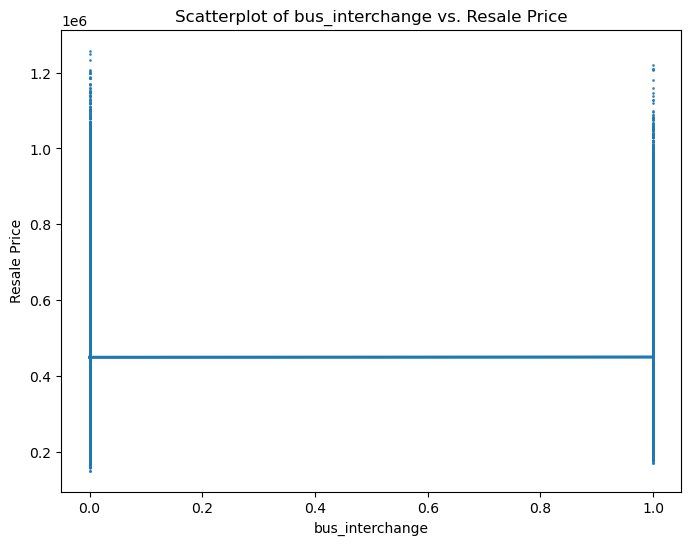

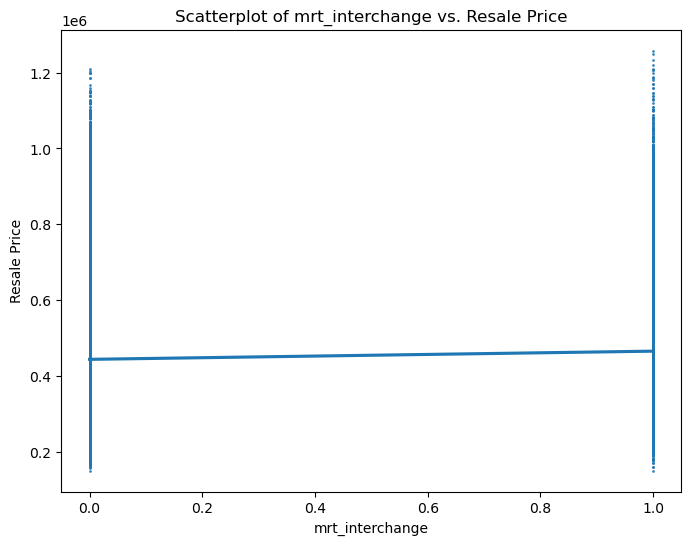

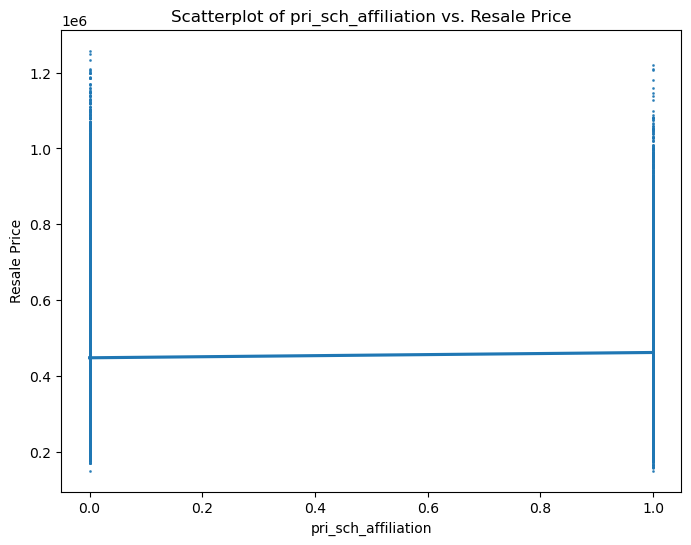

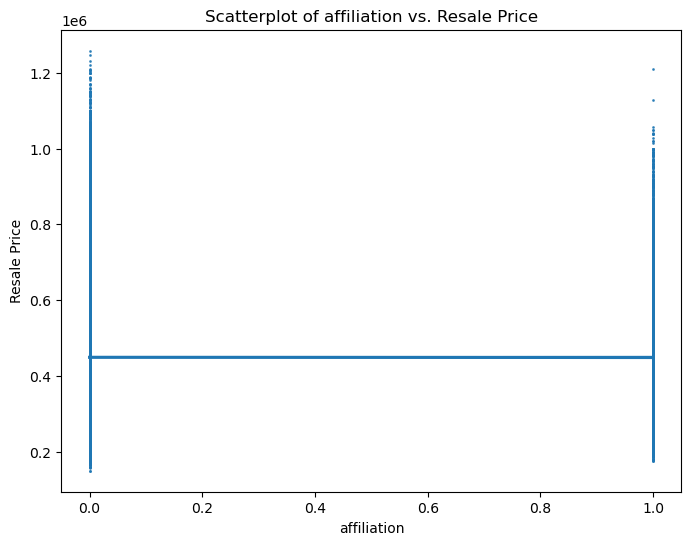

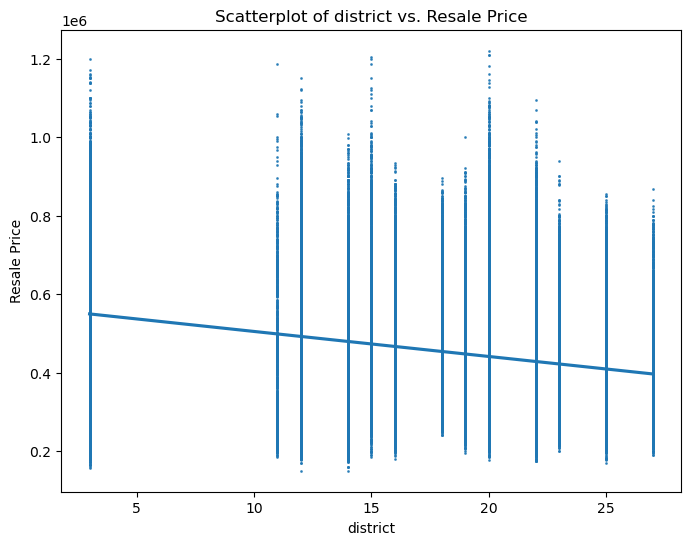

In [59]:
train_num_plot = train_num_sel.columns.tolist()

for col in train_num_plot:
    if col == 'resale_price':
        pass
    else:
        plt.figure(figsize=(8, 6))
        sns.regplot(x=train[col], y=train['resale_price'], scatter_kws={'s': 1})  
        plt.xlabel(col)
        plt.ylabel('Resale Price')
        plt.title(f'Scatterplot of {col} vs. Resale Price')
        plt.show()

**Other Findings from Scatterplots:**
1. **Floor Square meter:<br>** As expected, floor area has a very strong correlation to resale prices. Larger floor areas often mean more rooms and amenities, contributing to a higher overall value of the property. 
1. **Mid storey:<br>** This feature refers to the median value of storey_range that the property is located on. From the chart, we can tell that the higher the floor level a property is located on, the higher the resale price commanded. It seems that higher floor properties are more valued probably because homeowners enjoy better views and natural light compared to lower-level units.
1. **HDB age:<br>** Age of HDB is critical, especially for our Singapore context whereby most HDBs have a 99year lease. Older HDBs would hence have a shorter remaining lease duration. Older HDB flats may have undergone more wear and tear, requiring maintenance or renovation, which could reduce their value. Home owners considering selling their properties can hence be advised to sell their units sooner, rather than later.
2. **Max Floor Level:<br>** While this feature is not directly tied to the units on sale (units may be located on low level of a very tall HDB), it could imply other factors such as HDB age (in general, newer HDBs are of greater height than older HDBs). It could also imply the planning area. 